In [1]:
from src import *

## Table of Contents
- [Timeseries Comparison](#comparison)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

Movie name used for gradient: `'TC_400_sub-S09_ses-4_Sintel.csv'`. We as well introduce other movies for the same subjectin order to do permutation testing.

In [10]:
# Loading Gradient Example
regions  = list(index2region.keys())
G_movie, varM  = load('./resources/dynamic_grad/group_level/Sintel_grad.pkl')
G_rest , varR  = load('./resources/dynamic_grad/group_level/Rest_grad.pkl')


# Loading Matching Emotion Track
full_df = pd.read_csv('./data/emotion_compile.csv')
emo_df = full_df[full_df['filename']=='W_Sintel13.csv']

In [14]:
varM.shape

(306, 10)

In [12]:
varR.shape

(133, 10)

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

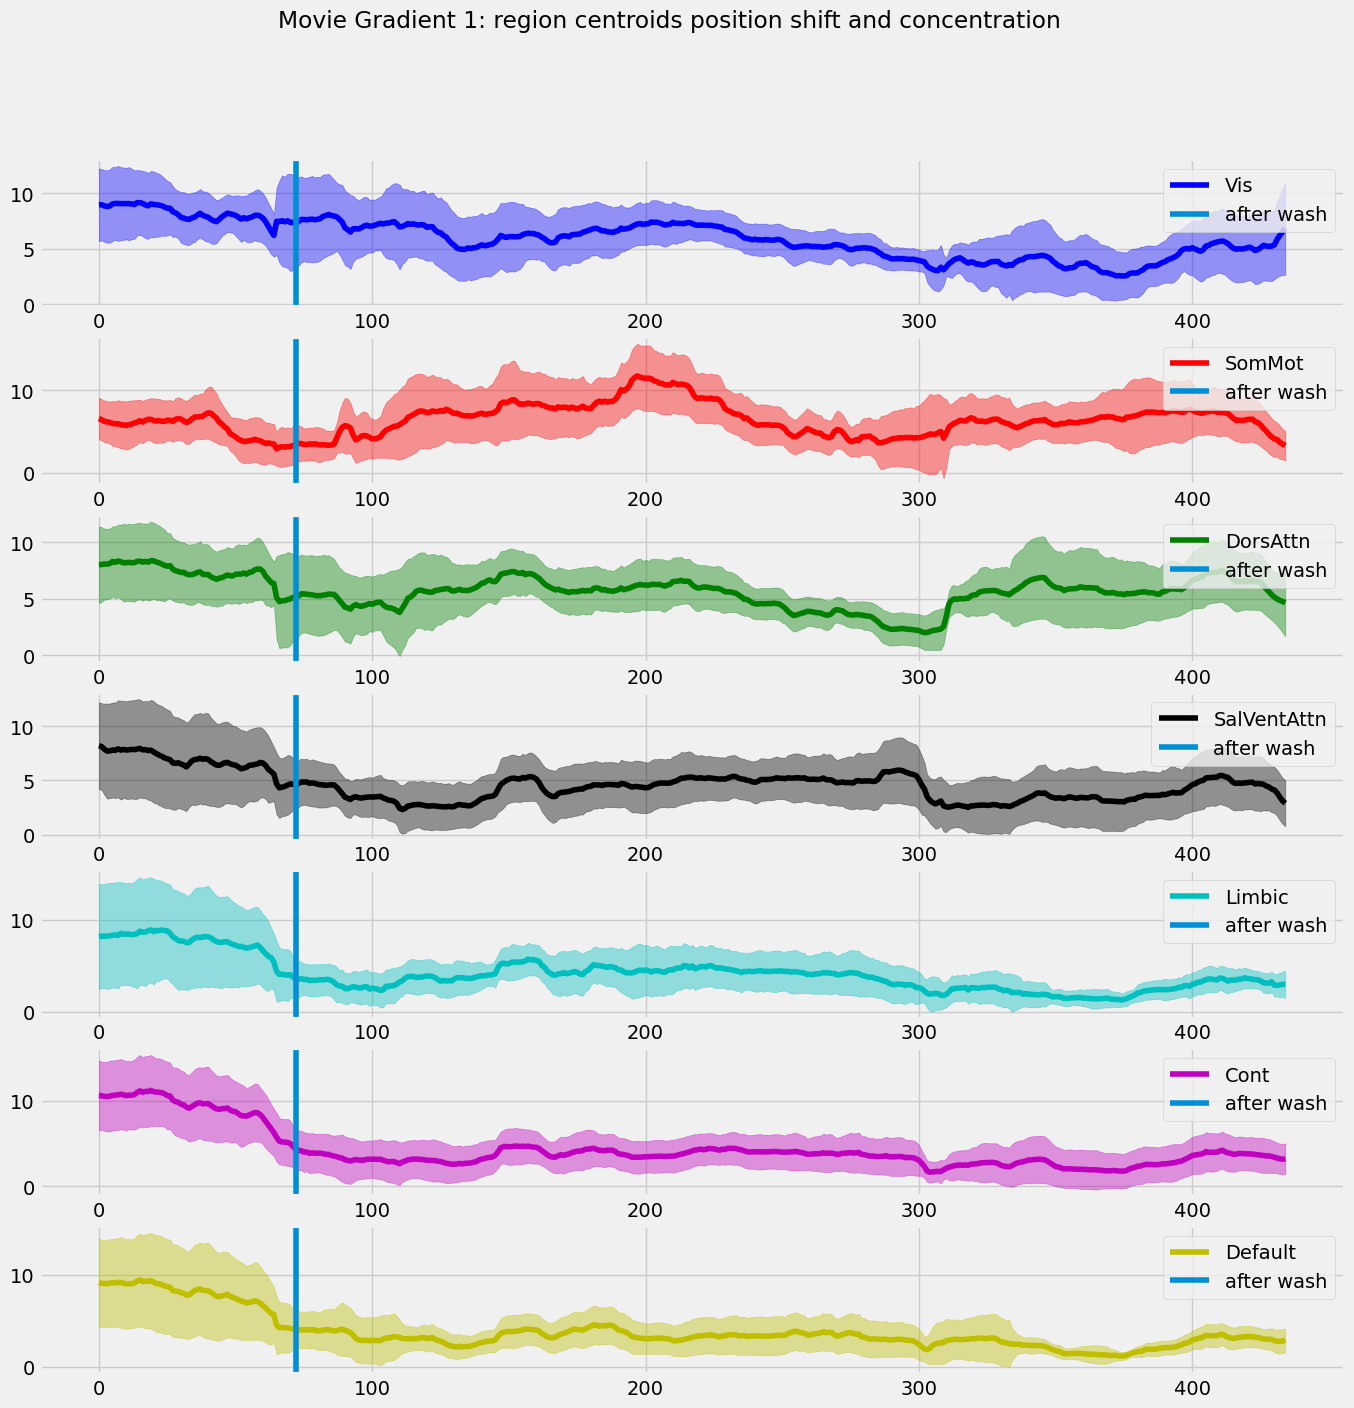

In [4]:
wash  = 93.9/ TR # duration in seconds for wash is 93.9 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec

n = len(regions)
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(regions):
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].axvline(x=wash, label='after wash')
    ax[idx].legend(loc=1)
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

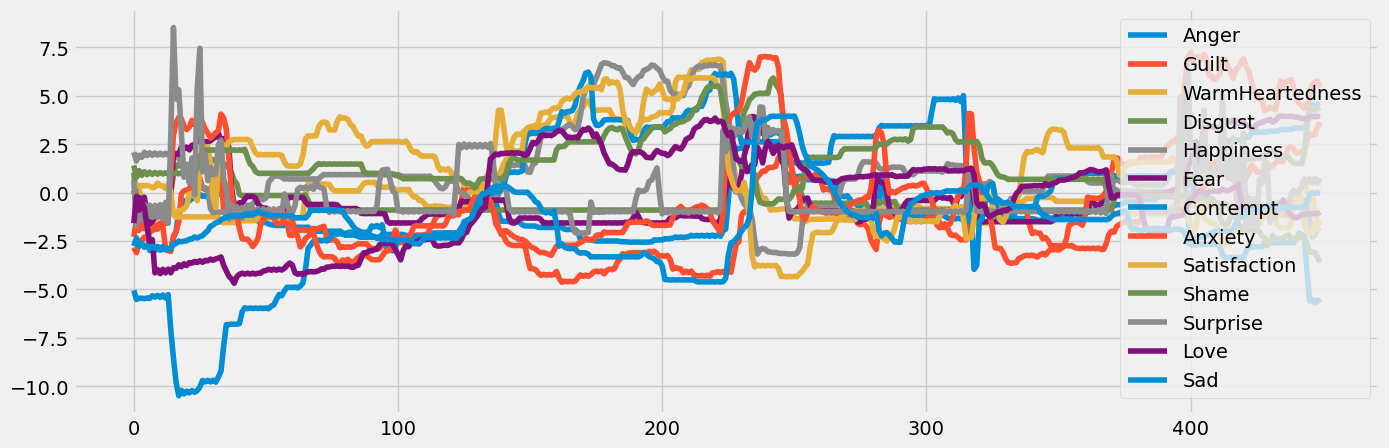

In [6]:
# emotions = "Interest, Joy, Surprise, Sadness, Anger, Disgust, Contempt, Self-Hostility, Fear, Shame, Shyness, Guilt".split(',')
# select   = ["Anxiety", "Anger", "Sad",  "Calm", "Satisfaction",  "Love", "Happiness", "Alert"]
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

plt.figure(figsize=(15,5))
for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    plt.plot(emo_series, label=emotion)

plt.legend()

Compute correlation between a given metric and emotion series

In [7]:
# Grid for each network of correlation with emotions
grad_idx = 0
smfactor = 1
tolshift = 0

n = len(regions)
m = len(select)

scores = np.zeros((n,m))

for idx, R in enumerate(regions):
    # Metric we use here would be variance of a cluster
    y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    # y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores[idx,jdx] = corr

In [8]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores2[idx,jdx] = corr


100%|██████████| 400/400 [00:10<00:00, 39.82it/s]


#### Correlation brain maps with 7 networks
We select here the max and visualize how well they correlate each other

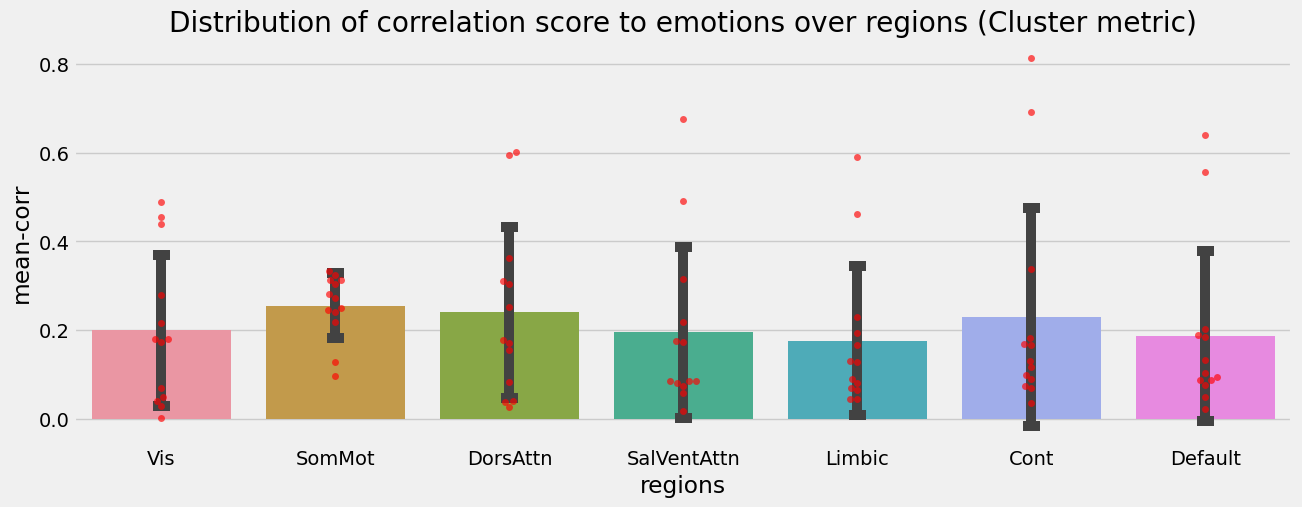

In [9]:
concat_region = np.concatenate([[r] * scores.shape[1] for r in regions])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores.flatten())}
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="r", alpha=.65)
plt.title("Distribution of correlation score to emotions over regions (Cluster metric)")
plt.show()

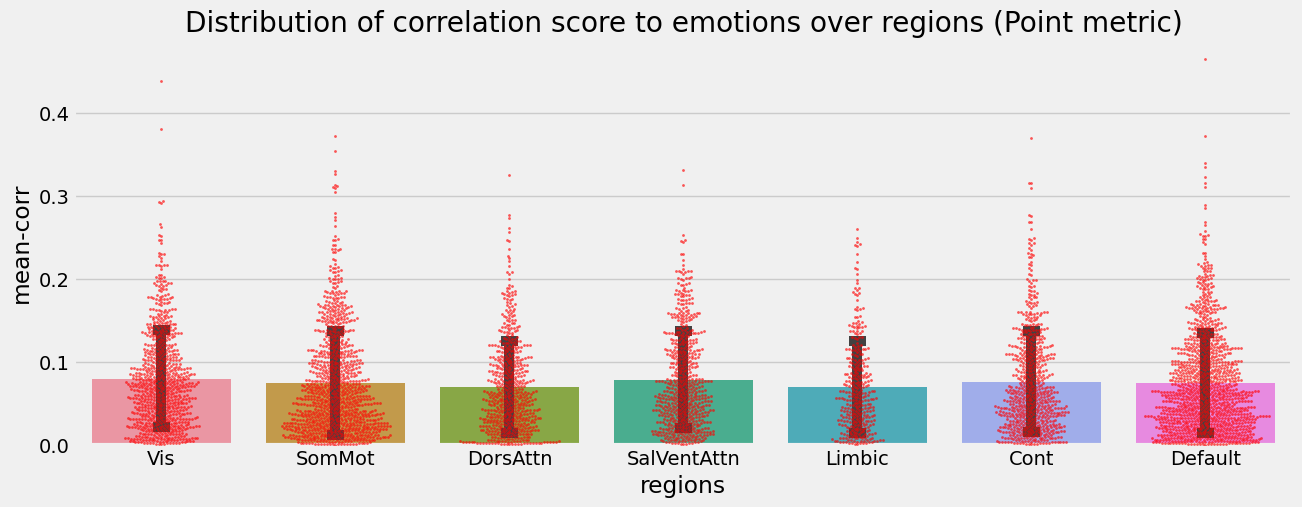

In [10]:
partial_region = load('./resources/region400yeo7.pkl')
partial_region = list(partial_region.values())

concat_region = np.concatenate([partial_region * scores2.shape[1]])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores2.flatten())}
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="r", alpha=.65, size=2)
plt.title("Distribution of correlation score to emotions over regions (Point metric)")
plt.show()

In [93]:
print(np.argsort(scores.flatten()))

print(scores.max(), scores.argmax(), scores.argmax()//m, scores.argmax()%m)
print(17//m,17%m)
print(19//m,19%m)
print(71//m,71%m)
print(76//m,76%m)


[71 76 45 84 37 32 58 89 50  6 63 11  9 35 67 41 13 14 38 16 26 18 25  7
 52 80 78 69 12  3 28  0 51 33 65 64 29 77 20 23 54 74 85 39 30 43 90 72
  4 59 47 82 27  2  1 86 10 48 31 73 36 56 60  5 68 53 42 57 46 49 83 79
 75 88 70 55 62 81 66 40 87 22 44 61 24  8 21 34 19 17 15]
0.3327206660994428 15 1 2
1 4
1 6
5 6
5 11


(0.33272066609944284, (0, 0), 1.0527321477680944e-12)


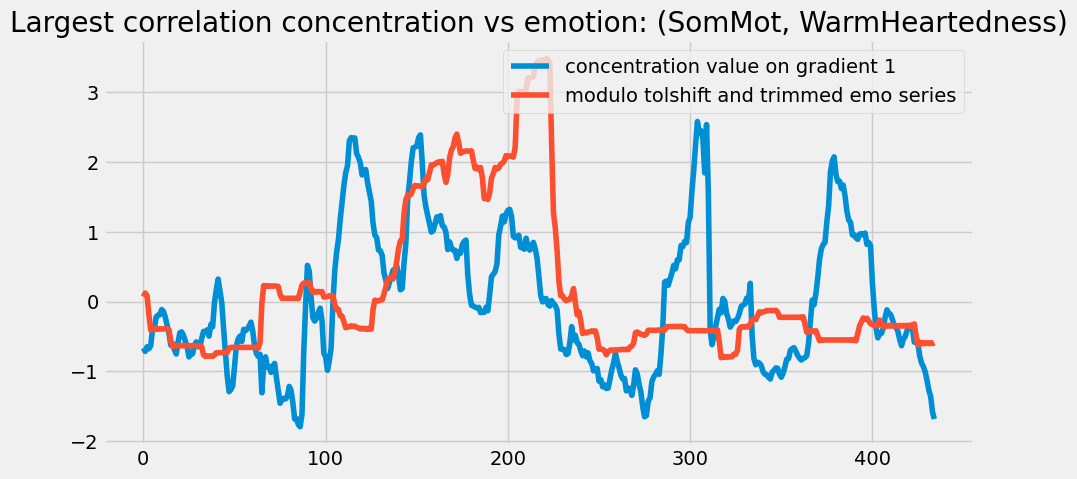

In [98]:
idxa = 1
idxb = 2
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(0.32372764856610337, (0, 0), 4.527489903954968e-12)


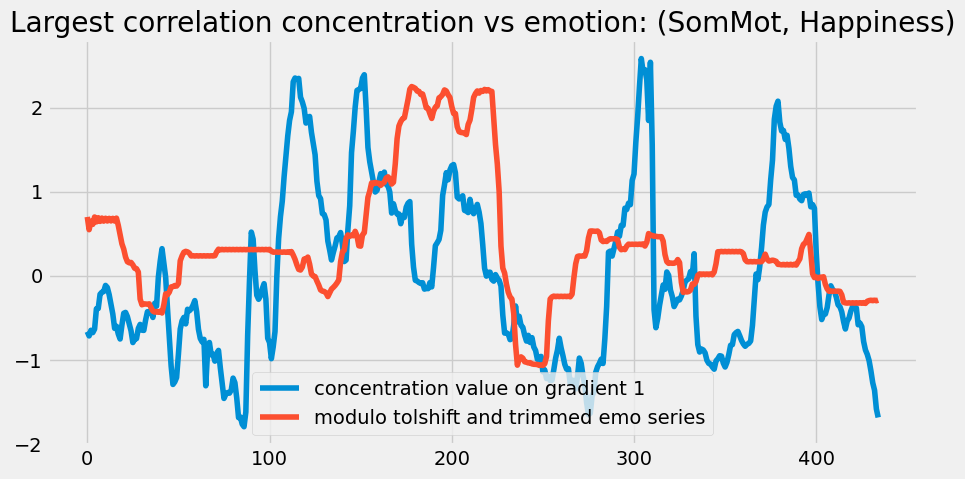

In [99]:
idxa = 1
idxb = 4
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(0.3133871891539666, (0, 0), 2.2845331180239208e-11)


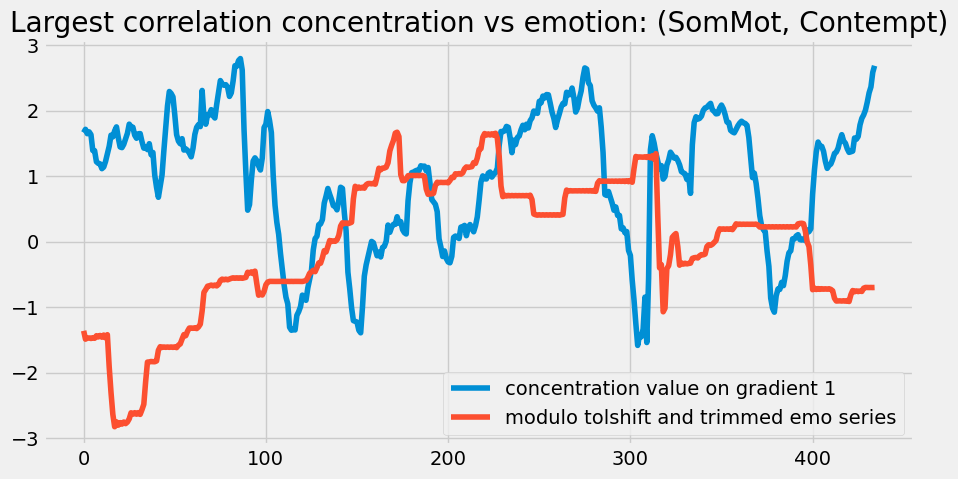

In [101]:
idxa = 1
idxb = 6
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(1-a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(-0.813376843916883, (0, 0), 6.300104489460296e-104)


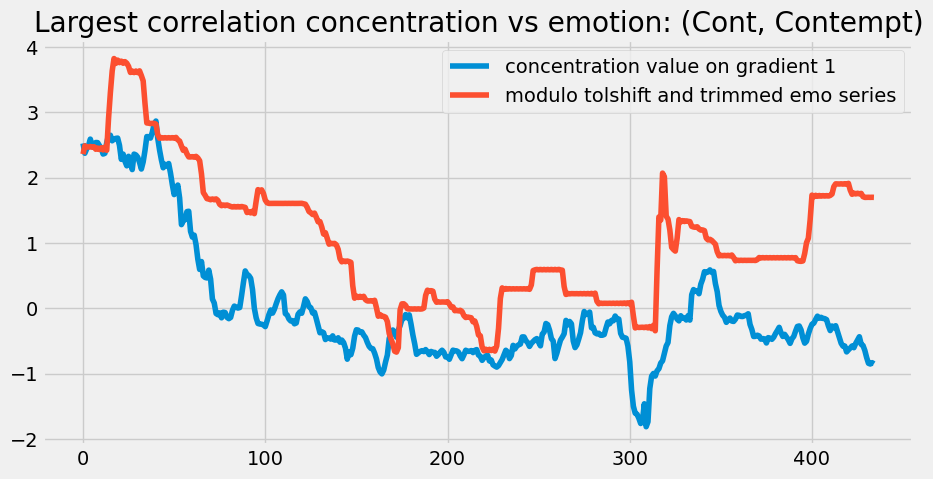

In [102]:
idxa = 5
idxb = 6
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(1-b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

(-0.6914115337466729, (0, 0), 4.067233116135134e-63)


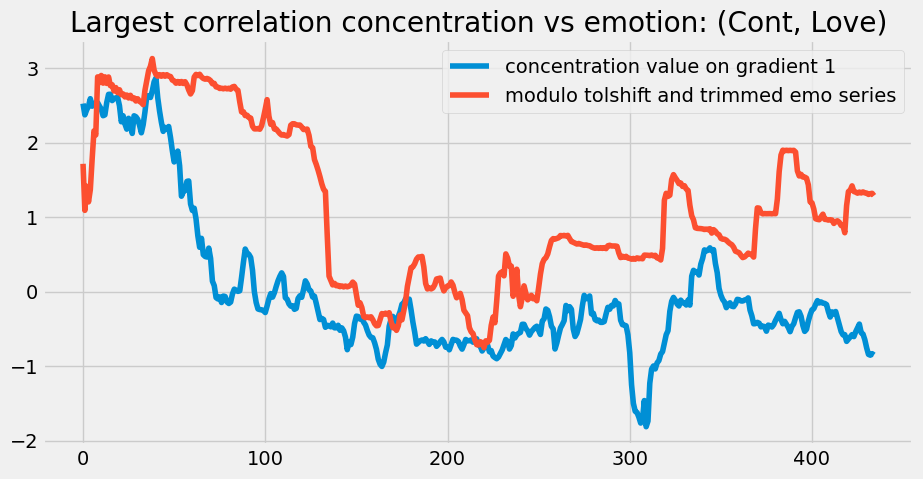

In [103]:
idxa = 5
idxb = 11
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
print(correlation_search(a,b[:a.shape[0]], 0, 1))

plt.figure(figsize=(10,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx + 1))
plt.plot(1-b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend()

In [ ]:
# # Uncomment for: Sanity Check of Eigenvector explained variances
# plot_eigenvector_importance(g_movie)
# plot_eigenvector_importance(g_rest)

#### Correlation brain maps with 400 parcellations

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


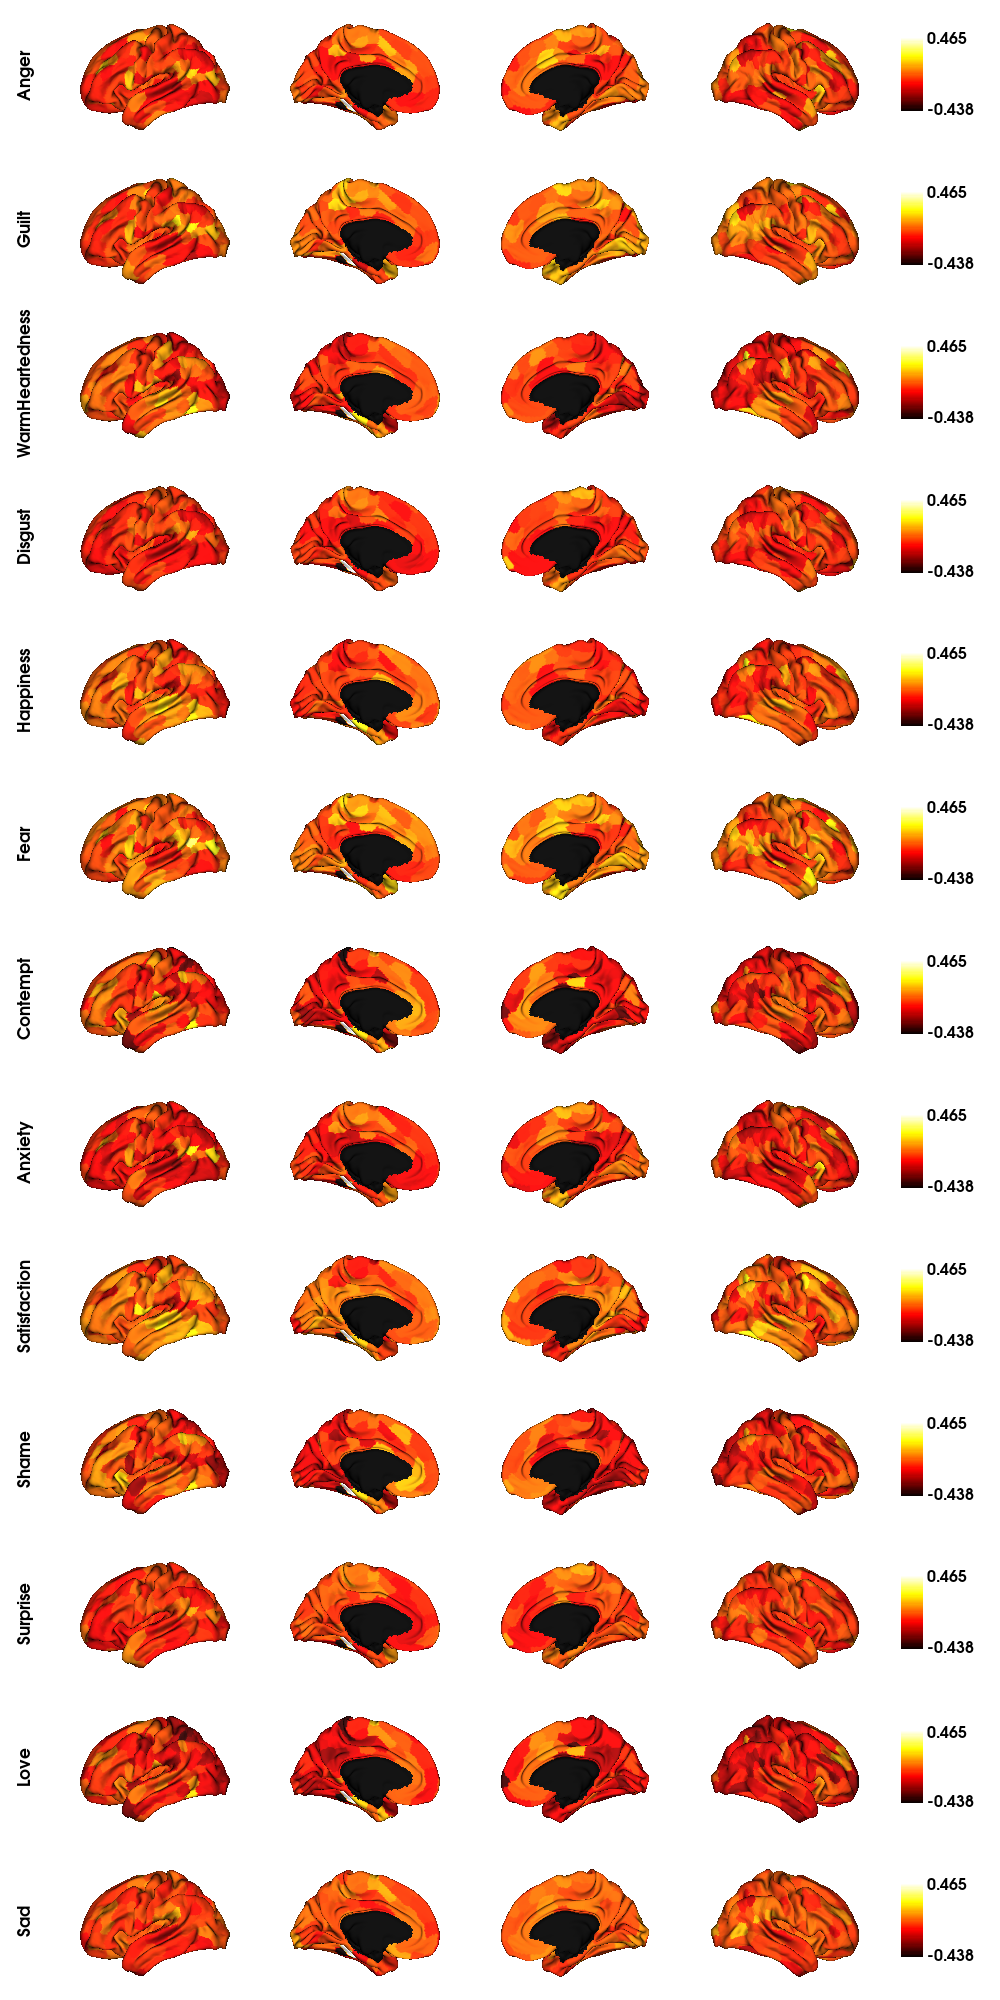

In [126]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = deepcopy(scores2.T)

grad = [None] * len(select)
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    gs[k][0]   = gs.min()
    gs[k][1]   = gs.max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='hot',
                 color_bar=True, label_text=select, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


#### Permutation Testing
TODO: for multiple pair emotions netowrk plot the null distributions

In [35]:
idxa = 5
idxb = 11

other_df = full_df[full_df.filename != 'W_Sintel13.csv']
order2 = list(other_df.filename.unique())
np.random.shuffle(order2)

concat_other  = np.array(other_df[other_df.item == select[idxb]]['score'])
concat_other2 = np.concatenate([other_df[(other_df.item == select[idxb]) & 
                            (other_df.filename == o)].score for o in order2])

In [36]:
# Obtained sample correlation
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)
cur,_,_ = correlation_search(zscore(a), zscore(b[:len(a)]), 0, 1)

In [18]:
discrete = []
for o in order2:
    f = other_df[(other_df.item == select[idxb]) & (other_df.filename == o)].score
    f = overlap_add(f, 1)
    m = min(len(f), len(a))
    corr,_,_ = correlation_search(zscore(a)[:m], zscore(f[:m]), 0, 1)
    discrete.append(corr)

In [40]:
# from mlxtend.evaluate import permutation_test
# permutation_test(a , c, method='approximate', num_rounds=10000, func=lambda x,y: np.corrcoef(x,y)[1][0], seed=0)

# another order of emotions series
null_distrib3 = []
for i in range(len(concat_other2) - len(a)):
    e = concat_other2[i:i+len(a)]
    e = overlap_add(e, 1)
    a, e = zscore(a), zscore(e)
    corr, _,_ = correlation_search(a,e, 0, 1)
    null_distrib3.append(corr)

# default order of emotions series
null_distrib2 = []
for i in range(len(concat_other) - len(a)):
    d = concat_other[i:i+len(a)]
    d = overlap_add(d, 1)
    a, d = zscore(a), zscore(d)
    corr, _,_ = correlation_search(a,d, 0, 1)
    null_distrib2.append(corr)

# shuffling gradient metrics series
np.random.seed(10)
nb_shuffle = 10000
samples = np.zeros((nb_shuffle, len(a)))
for i in range(nb_shuffle):
    ashuffle = deepcopy(a)
    np.random.shuffle(ashuffle)
    samples[i] = ashuffle

c = b[:a.shape[0]]

null_distrib = []
for i in range(len(samples)):
    null_distrib.append(correlation_search(samples[i], c, 0, 1)[0])


Might not be best permutation test as can be seen here in the another movie we obtain basically the same correlation strength. Careful to always to this plot to verify.

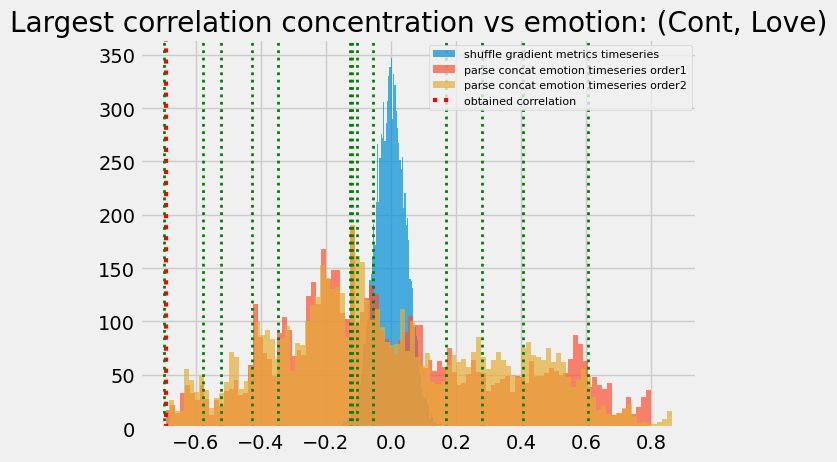

In [50]:
plt.hist(null_distrib, bins=100, alpha=0.7, label="shuffle gradient metrics timeseries")
plt.hist(null_distrib2, bins=100, alpha=0.7, label="parse concat emotion timeseries order1")
plt.hist(null_distrib3, bins=100, alpha=0.7, label="parse concat emotion timeseries order2")
plt.axvline(x=cur, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
for k in range(len(discrete)):
    plt.axvline(x=discrete[k], c='g', linestyle='dotted', linewidth=2)
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend(loc=1, prop={'size':8})

In [38]:
def null_score(null_distrib, sample):
    # single tail
    if np.sign(sample) == -1:
        score = np.mean(null_distrib < sample)
    else:
        score = np.mean(null_distrib > sample)
    return score

In [55]:
def moviemix_stat_test(totest, mainseries, mixseries):
    # Obtained sample correlation
    mainseries = overlap_add(mainseries, 1)
    m          = min(len(totest), len(mainseries))
    cur,_,_    = correlation_search(zscore(totest[:m]), zscore(mainseries[:m]), 0, 1)

    # generate null distribution
    ndistrib = []
    for i in range(len(concat_other) - len(totest)):
        b = mixseries[i:i+len(totest)]
        b = overlap_add(b, 1)
        a, b = zscore(totest), zscore(b)
        corr, _,_ = correlation_search(a,b, 0, 1)
        ndistrib.append(corr)

    ndistrib = np.asarray(ndistrib)
    nscore   = null_score(ndistrib, cur)
    return ndistrib, nscore, cur

In [56]:
def plot_nulldistribution(totest, mainseries, mixseries):
    ndistrib,nscore = moviemix_stat_test
    
    plt.hist(ndistrib, bins=100, alpha=0.7, label="null distribution")
    plt.axvline(x=nscore, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
    plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
    plt.legend(loc=1, prop={'size':8})
    plt.show()

In [57]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))
conf    = np.zeros((n,m))


other_df = full_df[full_df.filename != 'W_Sintel13.csv']

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series   = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened   = overlap_add(emo_series, smfactor)
        z2           = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)

        scores2[idx,jdx] = corr
        conf[idx,jdx] = nscore

 27%|██▋       | 109/400 [42:03<1:53:00, 23.30s/it]